In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report


df = pd.read_csv("ReviewsWithVotes.csv")

# fix votes nan to 0
df["votes"] = df["votes"].fillna(0)
# df["votes"] = df["votes"] - 1 # remove self votes

# # normalize votes
# df["votes"] = df["votes"] / df["votes"].max()


# high_quality_threshold = 0.45

# df["imputed_quality"] = (df["votes"] >= high_quality_threshold)*1
df["imputed_quality"] = (df["votes"] > 0) * 1 # sum of annotators votes > 1 ie (2 or 3)
# TODO: decide if this thereshold should be 0 or 1
# TODO:  Setting threshold to 0 (1,2,3 annotators) greatly improves performance => we should annotate more!


# convert boolean cols to int
df["again"] = df["again"].astype(int)
df["instructorEnjoyed"] = df["instructorEnjoyed"].astype(int)
df["instructorAgain"] = df["instructorAgain"].astype(int)




def get_vectorizer(df, text_column):
    """
    Vectorize the text column
    """
    vect = TfidfVectorizer(
        max_features=1000,
        max_df=0.8,
        min_df=0.1,
        stop_words="english",
    )
    vect.fit_transform(df[text_column])
    return vect






In [9]:
# Q: whats the latest date in the dataset?

print(df["reviewDate"].max())

# Q: how many reviews are there in the dataset?

print(len(df))

2023-04-21 18:09:01.856+00
1925


In [10]:
df["imputed_quality"].value_counts()

1    1036
0     889
Name: imputed_quality, dtype: int64

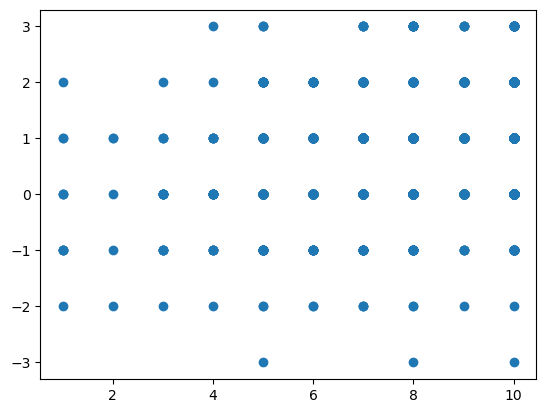

In [11]:
import matplotlib.pyplot as plt

# plt.hist(df["votes"], bins=6)


plt.scatter(df["instructorEnthusiasm"], df["votes"]) # these won't work



In [12]:
high_quality_df = df[df["imputed_quality"] == 1]


v = get_vectorizer(high_quality_df, "content")

X = v.transform(high_quality_df["content"])

print(v.get_feature_names_out())


bad_quality_df = df[df["votes"] < 0]

v_bad = get_vectorizer(bad_quality_df, "content")
X_bad = v_bad.transform(bad_quality_df["content"])

print(v_bad.get_feature_names_out())




['assignments' 'class' 'classes' 'content' 'course' 'definitely'
 'difficult' 'discussion' 'easy' 'engaging' 'enjoyed' 'exams' 'extremely'
 'final' 'fun' 'good' 'great' 'hard' 'homework' 'hours' 'interesting'
 'just' 'learn' 'lectures' 'like' 'lot' 'material' 'overall' 'papers'
 'pretty' 'prof' 'professor' 'reading' 'readings' 'really' 'recommend'
 'semester' 'students' 'super' 'taking' 'teaching' 'think' 'time'
 'understanding' 'week' 'work']
['boring' 'class' 'course' 'definitely' 'difficult' 'does' 'easy' 'exams'
 'good' 'great' 'hard' 'homework' 'hours' 'interesting' 'just' 'lectures'
 'like' 'lot' 'material' 'nice' 'pretty' 'professor' 'really' 'recommend'
 'students' 'super' 'took' 'work']


In [6]:
# y = df["imputed_quality"]

# x_df = pd.DataFrame(X.toarray(), columns=v.get_feature_names_out())
# # x_df["imputed_quality"] = labels

# from sklearn.model_selection import train_test_split


# X_train, X_test, y_train, y_test = train_test_split(x_df, y, test_size=0.15)

# from sklearn.linear_model import LogisticRegression

# lr = LogisticRegression(penalty="l2")
# lr.fit(X_train, y_train)

# y_pred = lr.predict(X_test)

# print(classification_report(y_test, y_pred))







In [13]:
sliders = [
    "rating",
    "difficulty",
    "value",
    "instructorEffectiveness",
    "instructorAccommodationLevel",
    "instructorEnthusiasm",
]

def get_default_slider_mse(row):
    return np.mean((row[sliders] - 5)**2)

df["default_mse"] = df.apply(get_default_slider_mse, axis=1)

In [14]:
def get_review_content_length(row):
    return (len(row["content"]) - 200)/200

df["content_length"] = df.apply(get_review_content_length, axis=1)


In [15]:
def review_content_larger_than_250(row):
    return (len(row["content"]) > 250) * 1

df["content_larger_than_250"] = df.apply(review_content_larger_than_250, axis=1)

In [16]:
# quality vs content_larger_than_250

# df["content_larger_than_250"].value_counts()

# df["imputed_quality"].value_counts()

df[df["content_larger_than_250"] == False]["imputed_quality"].value_counts()

0    373
1    108
Name: imputed_quality, dtype: int64

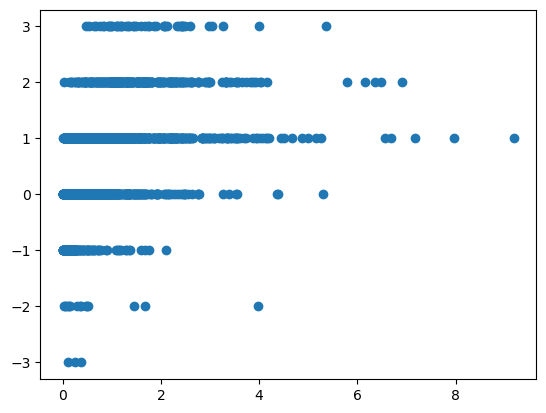

In [17]:
plt.figure()


plt.scatter(df["content_length"], df["votes"])

plt.show()

In [18]:
def get_average_sentence_length(row):
    return len(row["content"].split(" ")) / len(row["content"].split("."))


df["average_sentence_length"] = df.apply(get_average_sentence_length, axis=1)

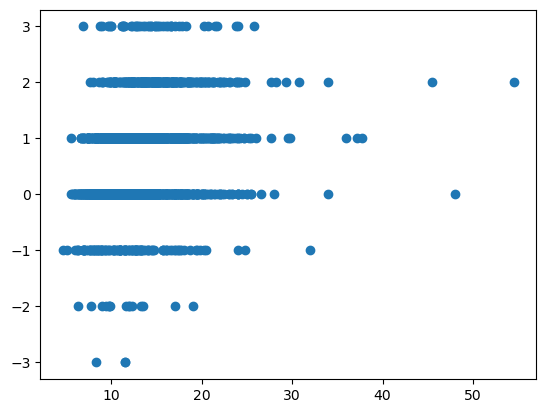

In [19]:
plt.figure()

plt.scatter(df["average_sentence_length"], df["votes"])

plt.show()

In [20]:
slider_cols = ["value", "difficulty", "rating", "instructorEffectiveness", "instructorEnthusiasm", "instructorAccommodationLevel"]

def get_variance(vals):
    return np.var(vals)

columns = ["value", "difficulty", "rating", "again", "instructorEffectiveness", "instructorEnthusiasm", "instructorAccommodationLevel", "instructorEnjoyed", "instructorAgain"]


default_slider_vals = {
    "value": 5,
    "difficulty": 5,
    "rating": 5,
    "again": 0,
    "instructorEffectiveness": 5,
    "instructorEnthusiasm": 5,
    "instructorAccommodationLevel": 5,
    "instructorEnjoyed": 0,
    "instructorAgain": 0
}

overly_negative_vals = {
    "value": 1,
    "difficulty": 10,
    "rating": 1,
    "again": 0,
    "instructorEffectiveness": 1,
    "instructorEnthusiasm": 1,
    "instructorAccommodationLevel": 1,
    "instructorEnjoyed": 0,
    "instructorAgain": 0
}

overly_positive_vals = {
    "value": 10,
    "difficulty": 1,
    "rating": 10,
    "again": 1,
    "instructorEffectiveness": 10,
    "instructorEnthusiasm": 10,
    "instructorAccommodationLevel": 10,
    "instructorEnjoyed": 1,
    "instructorAgain": 1
}

default_slider_vals_list = [default_slider_vals[col] for col in columns]
overly_negative_vals_list = [overly_negative_vals[col] for col in columns]
overly_positive_vals_list = [overly_positive_vals[col] for col in columns]

def get_mse(vals, expected_vals):
    return np.mean(np.square(vals-expected_vals))


In [21]:
df["default_mse"] = df[columns].apply(get_mse, axis=1, args=(default_slider_vals_list,))
df["overly_negative_mse"] = df[columns].apply(get_mse, axis=1, args=(overly_negative_vals_list,))
df["overly_positive_mse"] = df[columns].apply(get_mse, axis=1, args=(overly_positive_vals_list,))

df["slider_variance"] = df[slider_cols].apply(get_variance, axis=1)

In [22]:
# readability
# from readability import flesch_reading_ease, smog_index, dale_chall_readability_score

from textstat.textstat import textstatistics
import math


flesch_reading_ease = lambda x: textstatistics().flesch_reading_ease(x)
smog_index = lambda x: textstatistics().smog_index(x)
dale_chall_readability_score = lambda x: textstatistics().dale_chall_readability_score(x)

def get_fre_readability_score(row):
    return flesch_reading_ease(row["content"])

def get_smog_readability_score(row):
    return smog_index(row["content"])

def get_dale_chall_readability_score(row):
    return dale_chall_readability_score(row["content"])

df["fre_readability"] = df.apply(get_fre_readability_score, axis=1)
df["smog_readability"] = df.apply(get_smog_readability_score, axis=1)
df["dale_chall_readability"] = df.apply(get_dale_chall_readability_score, axis=1)


In [23]:
import math

def char_freq(text: str):
    """Calculates the frequency of each character in the text"""
    freq = {}
    for char in text:
        freq[char] = freq.get(char, 0) + 1
    return freq

def shannon_entropy(text: str):
    """Calculates the Shannon entropy of a text string"""
    length = len(text)
    freq = char_freq(text)

    entropy = 0
    for char in freq:
        prob = freq[char] / length
        entropy -= prob * math.log(prob, 2)

    return entropy


def get_review_entropy(row):
    return shannon_entropy(row["content"])

df["entropy"] = df.apply(get_review_entropy, axis=1)

In [24]:
def get_space_length_ratio(row):
    return len(row["content"].split(" ")) / len(row["content"])

def get_percent_difficult_words(row):
    # percent longer than 9 characters (2x average)
    return len([word for word in row["content"].split(" ") if len(word) > 9]) / len(row["content"].split(" "))


def get_count_period(row):
    return len([char for char in row["content"] if char == "."])

def get_count_exclamation(row):
    return len([char for char in row["content"] if char == "!"])

def get_count_question(row):
    return len([char for char in row["content"] if char == "?"])

def get_ratio_question_marks(row):
    return get_count_question(row) / len(row["content"])

def get_ratio_exclamation_marks(row):
    return get_count_exclamation(row) / len(row["content"])


def get_all_cap_words(row):
    return len([word for word in row["content"].split(" ") if word.isupper() and len(word) > 1])

def get_all_cap_words_ratio(row):
    return get_all_cap_words(row) / len(row["content"].split(" "))

# Features:
# Space to length ratio
# Percent difficult words
# Ratio of question marks
# Ratio of exclamation marks

df["space_length_ratio"] = df.apply(get_space_length_ratio, axis=1)
df["percent_difficult_words"] = df.apply(get_percent_difficult_words, axis=1)
df["ratio_question_marks"] = df.apply(get_ratio_question_marks, axis=1)
df["ratio_exclamation_marks"] = df.apply(get_ratio_exclamation_marks, axis=1)
df["ratio_all_cap_words"] = df.apply(get_all_cap_words_ratio, axis=1)



In [25]:
def word_freq(text: str):
    """Calculates the frequency of each word in the text"""
    freq = {}
    for word in text.split(" "):
        freq[word] = freq.get(word, 0) + 1
    return freq

def word_shannon_entropy(text: str):
    """Calculates the Shannon entropy of a text string"""
    length = len(text.split(" "))
    freq = word_freq(text)

    entropy = 0
    for word in freq:
        prob = freq[word] / length
        entropy -= prob * math.log(prob, 2)

    return entropy

def get_review_word_entropy(row):
    return word_shannon_entropy(row["content"].lower())

df["word_entropy"] = df.apply(get_review_word_entropy, axis=1)
df["word_diversity"] = df["word_entropy"] / df["content_length"] #this can create inf
df["word_diversity"] = df["word_diversity"].replace([np.inf, -np.inf], np.nan)
df["word_diversity"] = df["word_diversity"].fillna(df["word_diversity"].max())

In [26]:
from datetime import datetime, date, timedelta

def convert_term_string_to_date(term):
    # F22 -> 2022-09-01
    # S21 -> 2021-02-01
    # W21 -> 2021-01-01

    year = int(term[1:3])
    year = 2000 + year #Y2K baby!
    
    t_obj = {
        "F": date(year, 9, 1),
        "S": date(year, 2, 1),
        "W": date(year, 1, 1)
    }

    return t_obj[term[0]]



def time_between_course_and_review(row):
    # example reviewDate: 2022-10-24 03:16:49.083+00
    # only care aoout the date, not the time
    format = "%Y-%m-%d"
    time_string = row["reviewDate"]
    course_date = convert_term_string_to_date(row["semester"])

    date_string = time_string.split(" ")[0]


    review_date = datetime.strptime(date_string, format).date()

    return ((review_date - course_date).days) / 365



In [27]:
df["time_between_course_and_review"] = df.apply(time_between_course_and_review, axis=1)

In [28]:
# Sentiment Analysis

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

def get_sentiment_scores(row):
    return analyser.polarity_scores(row["content"])["compound"]

def get_neutrality_scores(row):
    return analyser.polarity_scores(row["content"])["neu"]

df["sentiment_scores"] = df.apply(get_sentiment_scores, axis=1)
df["neutrality_scores"] = df.apply(get_neutrality_scores, axis=1)

In [29]:
# Polarity
# a measure of if sentiment matches the ratings

def get_consistent_polarity(row):
    same_sign = 1 if row["sentiment_scores"] * (row["rating"]-5) > 0 else 0
    magnitude_threshold = 0.2
    same_magnitude = 1 if (abs(row["sentiment_scores"]) - abs(row["rating"]/10)) < magnitude_threshold else 0
    return same_sign * same_magnitude

def get_polarity(row):
    return row["sentiment_scores"] - ((row["rating"]-5)/10)

df["consistent_polarity"] = df.apply(get_consistent_polarity, axis=1)
df["polarity"] = df.apply(get_polarity, axis=1)

In [36]:
# KNN avg distance to nearest neighbor

from sklearn.neighbors import NearestNeighbors
import math

k = 5

def get_knn_avg_distance(df, row):

    X = df[["sentiment_scores", "neutrality_scores", "consistent_polarity", "polarity", "fre_readability", "smog_readability", "dale_chall_readability", "entropy", "word_entropy", "word_diversity", "time_between_course_and_review"]].to_numpy()

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(X)

    distances, indices = nbrs.kneighbors([row[["sentiment_scores", "neutrality_scores", "consistent_polarity", "polarity", "fre_readability", "smog_readability", "dale_chall_readability", "entropy", "word_entropy", "word_diversity", "time_between_course_and_review"]].to_numpy()])
    return distances[0].mean()



def get_knn_same_course_avg_distance(df, row):

    columns = [
        "rating",
        "difficulty",
        "value",
        "hours",
        "again",
        
        "default_mse",
        "content_length",
        "sentiment_scores",
    ]

    courseID = row["courseID"]
    X = df[df["courseID"] == courseID][columns].to_numpy()

    n_neighbors = min(k, len(X))

    if n_neighbors == 0:
        return math.nan

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(X)

    distances, indices = nbrs.kneighbors([row[columns].to_numpy()])

    return distances[0].mean()




df["knn_avg_distance"] = df.apply(lambda row: get_knn_avg_distance(df, row), axis=1)
df["knn_same_course_avg_distance"] = df.apply(lambda row: get_knn_same_course_avg_distance(df, row), axis=1)

# replace knn_same_course_avg_distance with avg if nan or inf
df["knn_same_course_avg_distance"] = df["knn_same_course_avg_distance"].replace([np.inf, -np.inf], np.nan)
df["knn_same_course_avg_distance"] = df["knn_same_course_avg_distance"].fillna(df["knn_same_course_avg_distance"].mean())




/Users/paulchoi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/Users/paulchoi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/Users/paulchoi/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your dat

In [30]:
# number of numbers
import re


def get_number_count(row):
    return len(re.findall(r'\d+', row["content"]))

df["number_count"] = df.apply(get_number_count, axis=1)


grade_re = re.compile(r'([A-F][+-]?)')

def mentions_grades(row):
    grade_like_words = ["grade", "curves", ]
    if any(word in row["content"] for word in grade_like_words):
        return 1
    
    if grade_re.search(row["content"]):
        return 1
    
    return 0


df["mentions_grades"] = df.apply(mentions_grades, axis=1)


def lowercase(string):
    return string.lower()

def mentions_prof_word(row):
    prof_like_words = ["prof", 
                       "professor", 
                       "teacher", 
                       "instructor", 
                       "lecturer", 
                       "tutor", 
                       "advisor", 
                       "dr",
                       "laoshi"
                       ]
    if any(word in lowercase(row["content"]) for word in prof_like_words):
        return 1
    
    return 0


df["mentions_prof_word"] = df.apply(mentions_prof_word, axis=1)



def contains_pronouns(row):
    pronoun_list = ["she", "he", "they", "them", "her", "him", "his", "hers", "their", "theirs"]
    re_word_boundary = r'\b%s\b'
    if any(re.search(re_word_boundary % word, lowercase(row["content"])) for word in pronoun_list):
        return 1

    return 0


def contains_personal_pronouns(row):
    pronoun_list = ["i", "me", "my", "mine", "we", "us", "our", "ours"]
    re_word_boundary = r'\b%s\b'
    if any(re.search(re_word_boundary % word, lowercase(row["content"])) for word in pronoun_list):
        return 1

    return 0


df["contains_pronouns"] = df.apply(contains_pronouns, axis=1)
df["contains_personal_pronouns"] = df.apply(contains_personal_pronouns, axis=1)

In [31]:
prof_id_to_name_map = {}

instructor_df = pd.read_csv("../data/Instructor.csv")

for index, row in instructor_df.iterrows():
    prof_id_to_name_map[row["instructorID"]] = row["name"]
    

def get_prof_name(row):
    prof_id = row["instructorID"]
    if prof_id in prof_id_to_name_map:
        return prof_id_to_name_map[prof_id]
    return None

def mentions_prof_name(row):
    prof_name = get_prof_name(row)
    if prof_name is None:
        return 0
    alternate_names = [*prof_name.split(" ")]
    if any(word in lowercase(row["content"]) for word in alternate_names):
        return 1
    # check for first name substring longer than 3 (nickname-like)
    for window in range(3, len(prof_name.split(" ")[0])):
        if prof_name.split(" ")[0][:window] in lowercase(row["content"]):
            return 1
    
    return 0


df["mentions_prof_name"] = df.apply(mentions_prof_name, axis=1)
    



FileNotFoundError: [Errno 2] No such file or directory: '../data/Instructor.csv'

In [32]:
def slider_diff_from_base(row, slider):
    return abs(row[slider] - 5)


diff_columns = [
    "rating",
    "difficulty",
    "value",
    "instructorEnthusiasm",
    "instructorEffectiveness"
]

# rating diff
#df["rating_diff"] = df.apply(lambda row: slider_diff_from_base(row, "rating"), axis=1)

for column in diff_columns:
    df[column+"_diff"] = df.apply(lambda row: slider_diff_from_base(row, column), axis=1)


rating_diff corr with imputed_quality: 0.1384959413532283


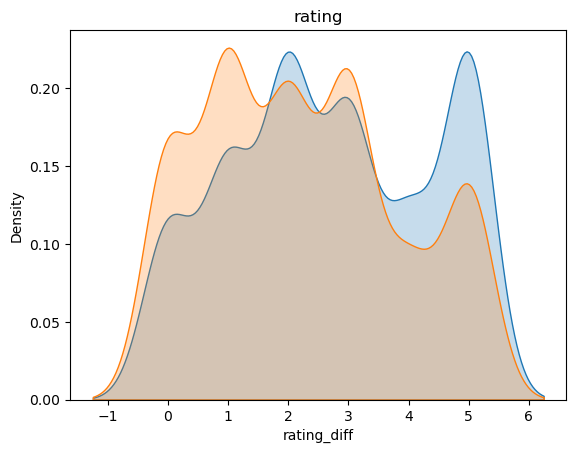

difficulty_diff corr with imputed_quality: -0.03911119613324394


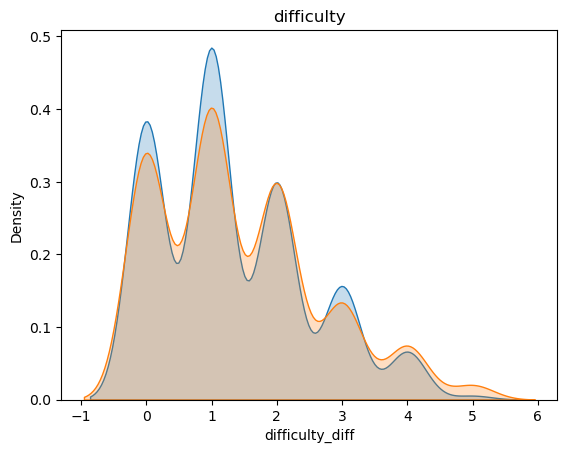

value_diff corr with imputed_quality: 0.09872790544291811


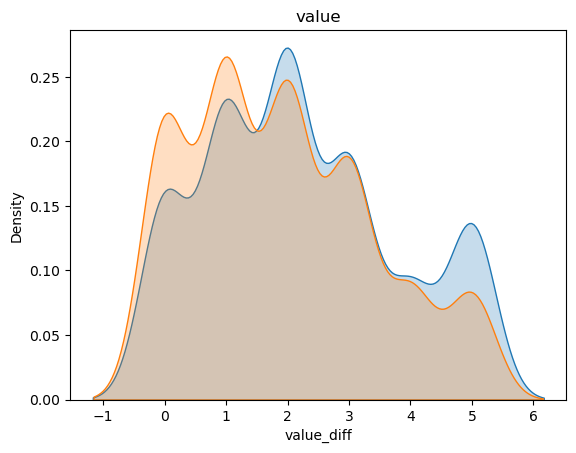

instructorEnthusiasm_diff corr with imputed_quality: 0.12521167571412636


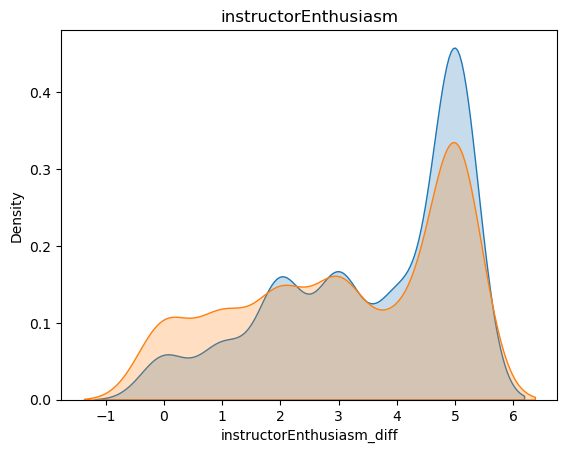

instructorEffectiveness_diff corr with imputed_quality: 0.1148492823053899


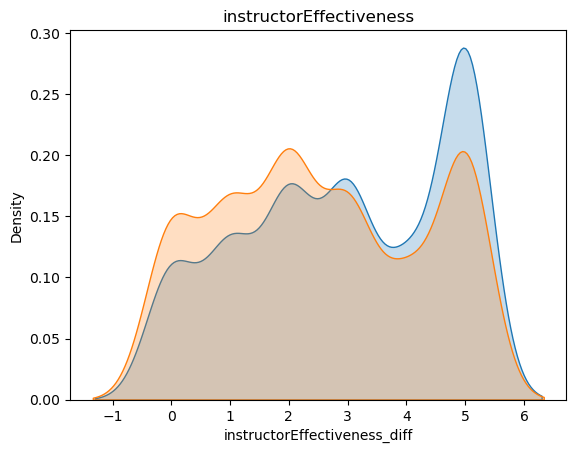

In [33]:
# kde plot of each diff column

for column in diff_columns:
    diff_col = column+"_diff"
    sns.kdeplot(df[df["imputed_quality"] == 1][diff_col], fill=True, label="imputed_quality = 1")
    sns.kdeplot(df[df["imputed_quality"] == 0][diff_col], fill=True, label="imputed_quality = 0")
    corr_with_imputed_quality = df[["imputed_quality", diff_col]].corr().iloc[0,1]
    print(f"{diff_col} corr with imputed_quality: {corr_with_imputed_quality}")
    plt.title(column)
    plt.show()

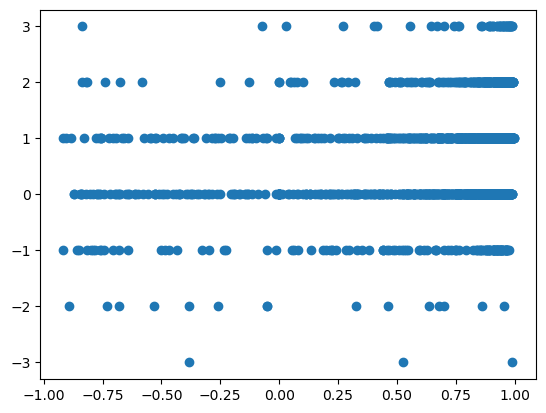

In [34]:
# sentiment_scores

plt.figure()

plt.scatter(df["sentiment_scores"], df["votes"])

plt.show()

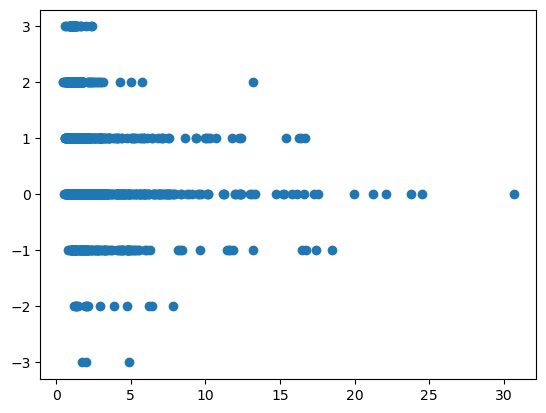

In [37]:
# entropy

plt.figure()

plt.scatter(df["knn_avg_distance"], df["votes"])

plt.show()

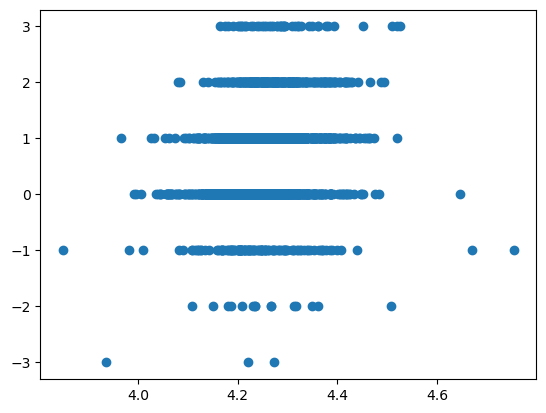

In [38]:
# entropy

plt.figure()

plt.scatter(df["entropy"], df["votes"])

plt.show()

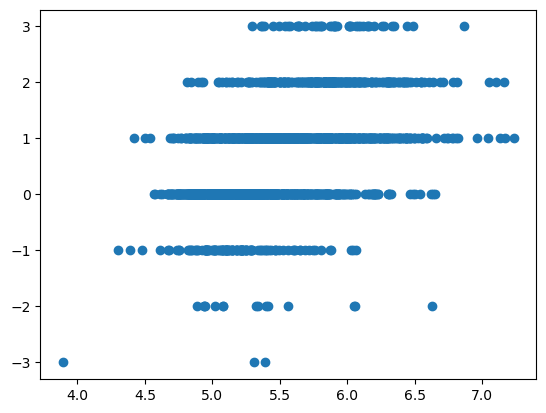

In [39]:
# word entropy

plt.figure()

plt.scatter(df["word_entropy"], df["votes"])

plt.show()

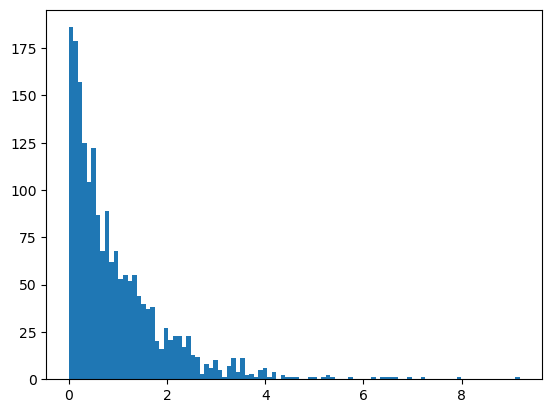

In [40]:
# hist of content length

plt.figure()

plt.hist(df["content_length"], bins=100)

plt.show()

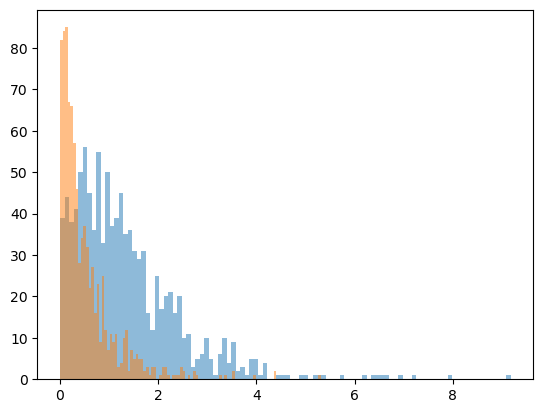

In [41]:
# hist of content length x imputed_quality

plt.figure()

plt.hist(df[df["imputed_quality"] == 1]["content_length"], bins=100, alpha=0.5, label="imputed_quality = 1")
plt.hist(df[df["imputed_quality"] == 0]["content_length"], bins=100, alpha=0.5, label="imputed_quality = 0")

plt.show()

<AxesSubplot:xlabel='content_length', ylabel='Density'>

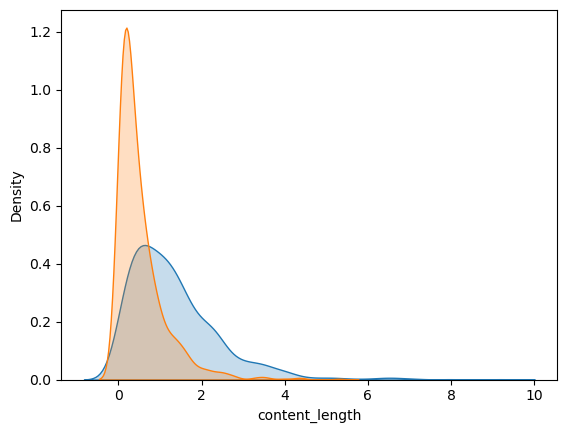

In [42]:
sns.kdeplot(df[df["imputed_quality"] == 1]["content_length"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["content_length"], fill=True, label="imputed_quality = 0")

<AxesSubplot:xlabel='rating_diff', ylabel='Density'>

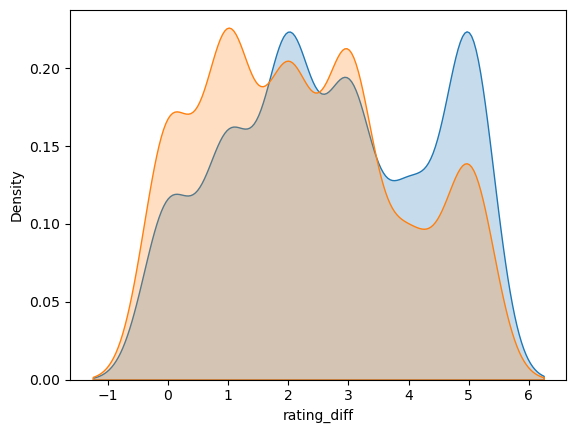

In [43]:
sns.kdeplot(df[df["imputed_quality"] == 1]["rating_diff"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["rating_diff"], fill=True, label="imputed_quality = 0")

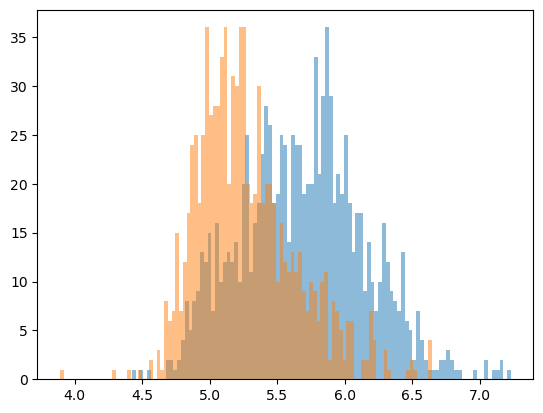

In [44]:

plt.figure()

plt.hist(df[df["imputed_quality"] == 1]["word_entropy"], bins=100, alpha=0.5, label="imputed_quality = 1")
plt.hist(df[df["imputed_quality"] == 0]["word_entropy"], bins=100, alpha=0.5, label="imputed_quality = 0")

plt.show()

<AxesSubplot:xlabel='word_entropy', ylabel='Density'>

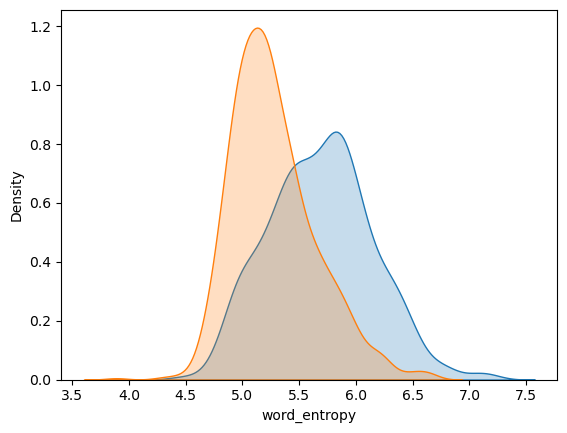

In [45]:
sns.kdeplot(df[df["imputed_quality"] == 1]["word_entropy"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["word_entropy"], fill=True, label="imputed_quality = 0")

<AxesSubplot:xlabel='space_length_ratio', ylabel='Density'>

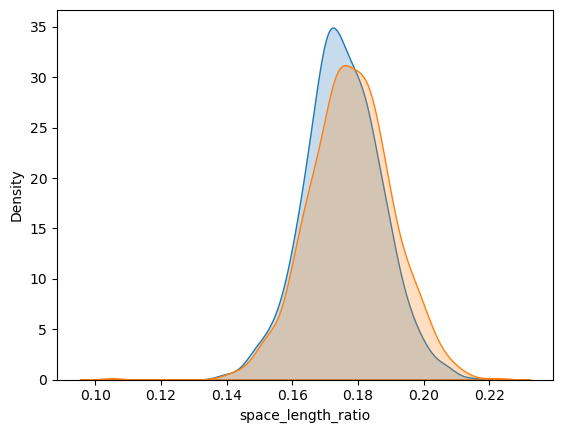

In [46]:
sns.kdeplot(df[df["imputed_quality"] == 1]["space_length_ratio"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["space_length_ratio"], fill=True, label="imputed_quality = 0")

<AxesSubplot:xlabel='mentions_prof_word', ylabel='Density'>

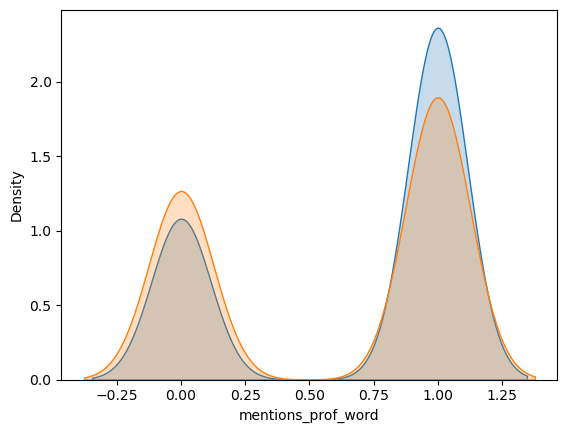

In [47]:
# kde for mentions_prof_word

sns.kdeplot(df[df["imputed_quality"] == 1]["mentions_prof_word"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["mentions_prof_word"], fill=True, label="imputed_quality = 0")


<AxesSubplot:xlabel='contains_pronouns', ylabel='Density'>

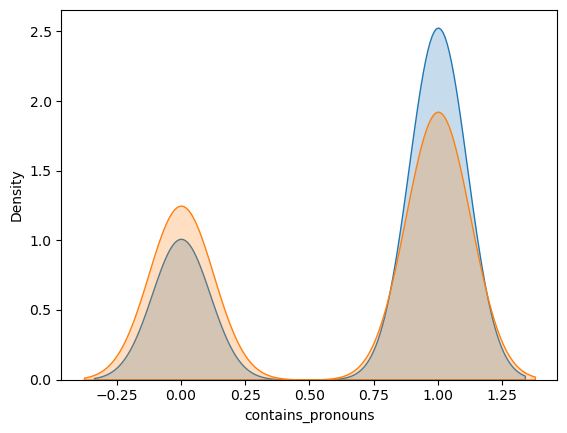

In [48]:
sns.kdeplot(df[df["imputed_quality"] == 1]["contains_pronouns"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["contains_pronouns"], fill=True, label="imputed_quality = 0")

<AxesSubplot:xlabel='average_sentence_length', ylabel='Density'>

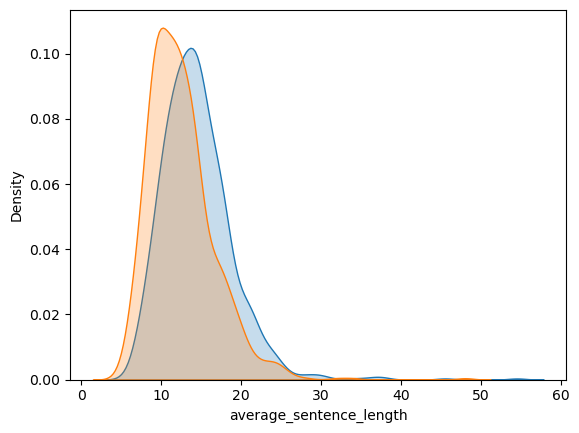

In [49]:
sns.kdeplot(df[df["imputed_quality"] == 1]["average_sentence_length"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["average_sentence_length"], fill=True, label="imputed_quality = 0")

<AxesSubplot:xlabel='ratio_all_cap_words', ylabel='Density'>

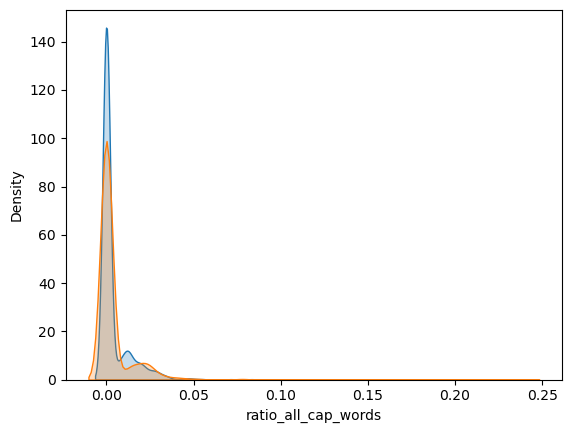

In [50]:
sns.kdeplot(df[df["imputed_quality"] == 1]["ratio_all_cap_words"], fill=True, label="imputed_quality = 1")
sns.kdeplot(df[df["imputed_quality"] == 0]["ratio_all_cap_words"], fill=True, label="imputed_quality = 0")

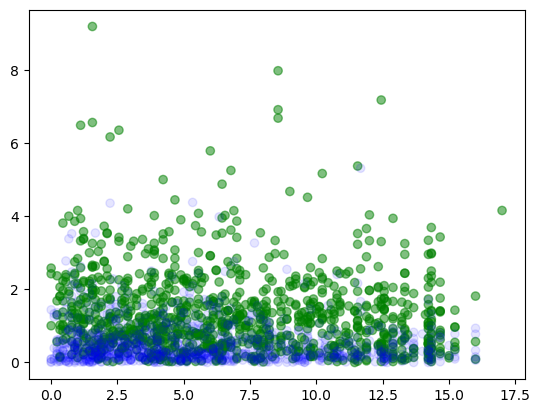

In [51]:
plt.figure()

color_map = {
    0: "blue",
    1: "green"
}

alpha_map = {
    0: 0.1,
    1: 0.5
}

ax = plt.scatter(df["default_mse"], df["content_length"], c=df["imputed_quality"].map(color_map), alpha=df["imputed_quality"].map(alpha_map))

plt.show()

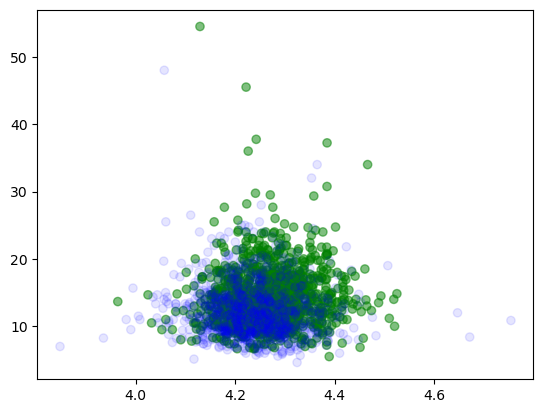

In [52]:
plt.figure()

color_map = {
    0: "blue",
    1: "green"
}

alpha_map = {
    0: 0.1,
    1: 0.5
}

ax = plt.scatter(df["entropy"], df["average_sentence_length"], c=df["imputed_quality"].map(color_map), alpha=df["imputed_quality"].map(alpha_map))

plt.show()

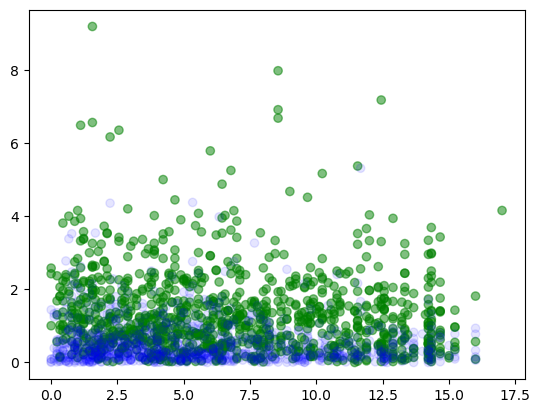

In [53]:
plt.figure()

color_map = {
    0: "blue",
    1: "green"
}

alpha_map = {
    0: 0.1,
    1: 0.5
}

ax = plt.scatter(df["default_mse"], df["content_length"], c=df["imputed_quality"].map(color_map), alpha=df["imputed_quality"].map(alpha_map))

plt.show()

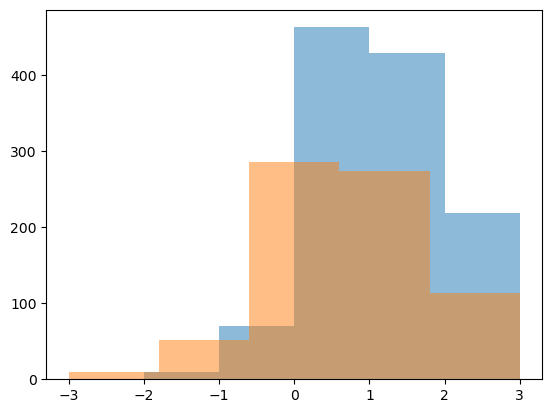

In [54]:
plt.figure()

color_map = {
    0: "blue",
    1: "green"
}

alpha_map = {
    0: 0.1,
    1: 0.5
}

plt.hist(df[df["wasAuthorized"] == 1]["votes"], bins=5, alpha=0.5, label="imputed_quality = 1")
plt.hist(df[df["wasAuthorized"] == 0]["votes"], bins=5, alpha=0.5, label="imputed_quality = 0")

plt.show()

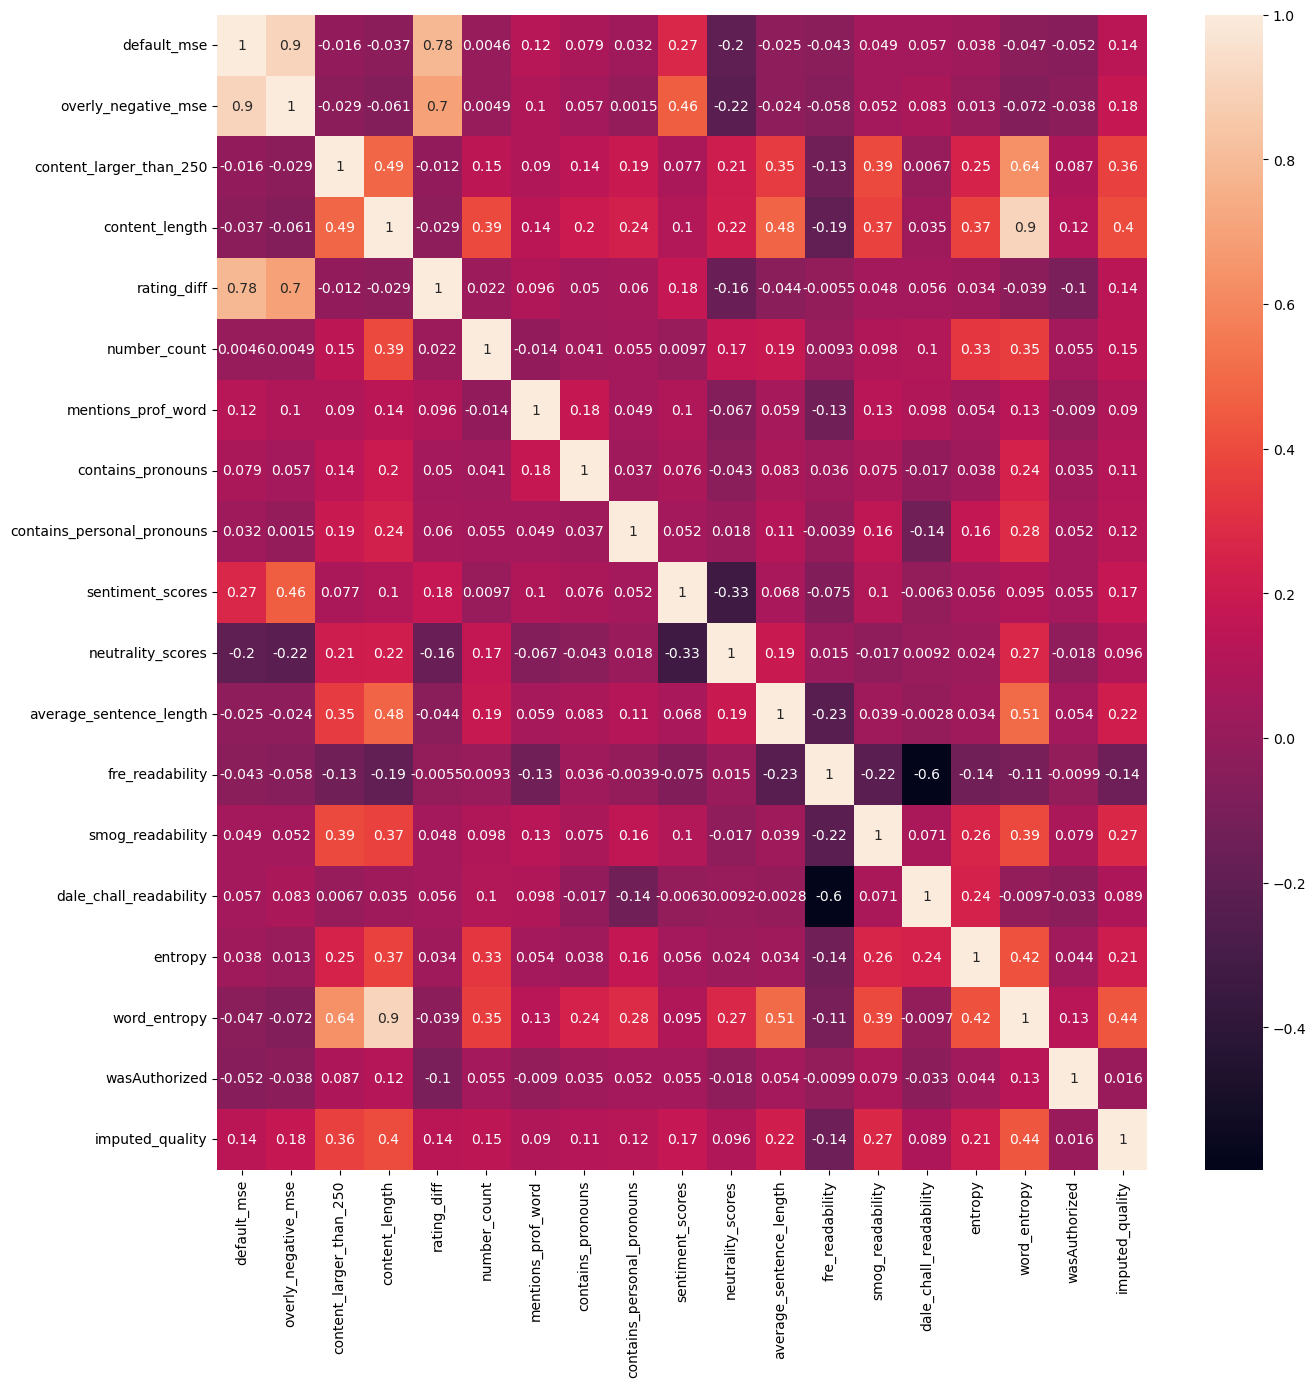

In [55]:
# cor
import seaborn as sns


corr_features = [
    "default_mse",
    "overly_negative_mse",
    # "overly_positive_mse",
    # "slider_variance",
    # "time_between_course_and_review",

    # "knn_avg_distance",
    "content_larger_than_250",
    "content_length",

    "rating_diff",

    # "space_length_ratio", #sucks
    # "percent_difficult_words", #sucks
    # "ratio_question_marks", #sucks
    # "ratio_exclamation_marks", #sucks


    "number_count",
    "mentions_prof_word",
    "contains_pronouns",
    "contains_personal_pronouns",
    # "mentions_prof_name",
    # "mentions_grades", #sucks

    "sentiment_scores",
    "neutrality_scores",
      
    # "polarity", #sucks
    # "consistent_polarity",
    
    "average_sentence_length",
    "fre_readability",
    "smog_readability",
    "dale_chall_readability",
    "entropy",
    "word_entropy",
    "wasAuthorized",
    # "word_diversity",

]

corr_features.append("imputed_quality")

plt.figure(figsize=(15,15))

sns.heatmap(df[corr_features].corr(), annot=True)
            
plt.show()

In [56]:
# LR

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

seed = 42

X_words = v.transform(df["content"])
X_words_row_sum = X_words.sum(axis=1)

X = df[corr_features[:-1]]
X = np.concatenate((X, X_words.toarray()), axis=1)
X = np.concatenate((X, X_words_row_sum), axis=1)

y = df["imputed_quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

lr = LogisticRegression(
    penalty="l2",
    max_iter=1e12,
    class_weight="balanced",
    random_state=seed,
)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))




/Users/paulchoi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.75      0.73       178
           1       0.77      0.73      0.75       207

    accuracy                           0.74       385
   macro avg       0.74      0.74      0.74       385
weighted avg       0.74      0.74      0.74       385

[[133  45]
 [ 55 152]]


/Users/paulchoi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [57]:
# RF


from sklearn.ensemble import RandomForestClassifier

seed = 42

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=seed,
    class_weight="balanced",
    max_features="sqrt",
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))




/Users/paulchoi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


              precision    recall  f1-score   support

           0       0.71      0.71      0.71       178
           1       0.75      0.75      0.75       207

    accuracy                           0.74       385
   macro avg       0.73      0.73      0.73       385
weighted avg       0.74      0.74      0.74       385

[[127  51]
 [ 51 156]]


/Users/paulchoi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [64]:
# corr of X

columns = corr_features[:-1]
columns.extend(["word_" + word for word in v.get_feature_names_out()])
columns.append("total_word_sum")

xydf = pd.DataFrame(X, columns = columns)
xydf['imputed_quality'] = y

# print(xydf.corr(numeric_only=True))

# get sorted list of columns with highest correlation to imputed_quality
print(xydf.corr(numeric_only=True)["imputed_quality"].sort_values(ascending=False).head(20))
print("=====================================")
print(xydf.corr(numeric_only=True)["imputed_quality"].sort_values(ascending=True).head(5)) # negative correlation


# xdf = pd.DataFrame(X, columns = columns)
# print(xdf.corr(numeric_only=True))

ValueError: Shape of passed values is (1925, 18), indices imply (1925, 65)

In [59]:
# Multiclass (-1, 0, 1) LR

def get_mutliclass_quality(row):
    if row["votes"] < 0:
        return -1
    if row["votes"] > 1:
        return 1
    
    return 0

df["imputed_multiclass_quality"] = df.apply(get_mutliclass_quality, axis=1)

In [60]:
df["imputed_multiclass_quality"].value_counts()

 0    1452
 1     333
-1     140
Name: imputed_multiclass_quality, dtype: int64

In [61]:
# Multiclass LR

from sklearn.linear_model import LogisticRegression

X_words = v.transform(df["content"])
X_words_row_sum = X_words.sum(axis=1)

X = df[corr_features[:-1]]
X = np.concatenate((X, X_words.toarray()), axis=1)
X = np.concatenate((X, X_words_row_sum), axis=1)

y = df["imputed_multiclass_quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

lr = LogisticRegression(
    penalty="l2",
    max_iter=1e10,
    # class_weight="balanced",
)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

/Users/paulchoi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


              precision    recall  f1-score   support

          -1       0.25      0.07      0.11        14
           0       0.76      0.92      0.83       146
           1       0.27      0.09      0.14        33

    accuracy                           0.72       193
   macro avg       0.43      0.36      0.36       193
weighted avg       0.64      0.72      0.66       193

[[  1  13   0]
 [  3 135   8]
 [  0  30   3]]


/Users/paulchoi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


=> Multiclass LR is not helpful

In [62]:
# corr relative to imputed_multiclass_quality

columns = corr_features[:-1]
# columns.extend(["word_" + word for word in v.get_feature_names_out()])
# columns.append("word_sum")

X = df[columns].to_numpy()

xydf = pd.DataFrame(X, columns = columns)
xydf['imputed_multiclass_quality'] = y

xydf.corr()["imputed_multiclass_quality"].sort_values(ascending=False).head(20)

imputed_multiclass_quality    1.000000
word_entropy                  0.367161
content_length                0.339023
content_larger_than_250       0.294690
average_sentence_length       0.217329
smog_readability              0.214721
sentiment_scores              0.191251
overly_negative_mse           0.179583
entropy                       0.154153
number_count                  0.104076
default_mse                   0.096454
neutrality_scores             0.083085
contains_pronouns             0.078792
mentions_prof_word            0.076714
dale_chall_readability        0.069858
contains_personal_pronouns    0.069810
rating_diff                   0.064819
wasAuthorized                 0.045574
fre_readability              -0.140438
Name: imputed_multiclass_quality, dtype: float64